# **Random Forest Training & Evaluation Pipeline** 

This notebook automates data loading, preprocessing, model training with hyperparameter tuning, evaluation, and basic visualizations for our Heron WellNest project.

---

## **Setup and Imports**

In [15]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, validation_curve, StratifiedKFold
from sklearn.metrics import classification_report, roc_auc_score, matthews_corrcoef, confusion_matrix, ConfusionMatrixDisplay, balanced_accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.utils import shuffle
from sklearn.feature_selection import f_classif, mutual_info_classif
import seaborn as sns
from sklearn.decomposition import PCA
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from collections import Counter

---
## **Configurations**


In [16]:
DATA_PATH = '../../data/classification/synthetic_dataset.csv'
# Path where the trained model will be saved
MODEL_PATH = '../../models/classification/random_forest.joblib'

---
## **Load Data**


In [17]:
df = pd.read_csv(DATA_PATH)

target_col = 'WellbeingClass'

labels = df[target_col].unique()
feature_cols = ["p_anxiety", "p_normal", "p_depression", "p_suicidal", "p_stress", "gratitude_flag",
                "Depressed","Sad","Exhausted","Hopeless","Anxious",
                "Angry","Stressed","Restless","Calm","Relaxed",
                "Peaceful","Content","Happy","Energized","Excited",'Motivated']

print(df[target_col].value_counts())
df.head()

WellbeingClass
Struggling    1423
InCrisis       811
Thriving       431
Excelling      220
Name: count, dtype: int64


,p_anxiety,p_normal,p_depression,p_suicidal,p_stress,gratitude_flag,WellbeingClass,Depressed,Sad,Exhausted,...,Stressed,Restless,Calm,Relaxed,Peaceful,Content,Happy,Energized,Excited,Motivated
0,0.000000,0.000000,0.000000,0.000000,0.000000,1,Thriving,0,0,0,...,0,0,1,0,0,1,0,0,0,0
1,0.307574,0.123478,0.142580,0.147782,0.278586,0,Struggling,0,0,0,...,0,0,1,0,1,0,0,0,0,1
2,0.000000,0.000000,0.000000,0.000000,0.000000,0,InCrisis,0,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0.246233,0.174566,0.277604,0.151734,0.149863,0,Struggling,0,0,0,...,0,1,0,0,1,0,0,1,0,0
4,0.187346,0.243826,0.211637,0.120585,0.236605,1,Struggling,0,0,0,...,0,1,0,1,0,0,0,0,0,0


----
## **Data visualization**


### **1. Target Distribution**


C:\Users\PC\AppData\Local\Temp\ipykernel_12940\1134603404.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=target_col, data=df, palette="Set2")


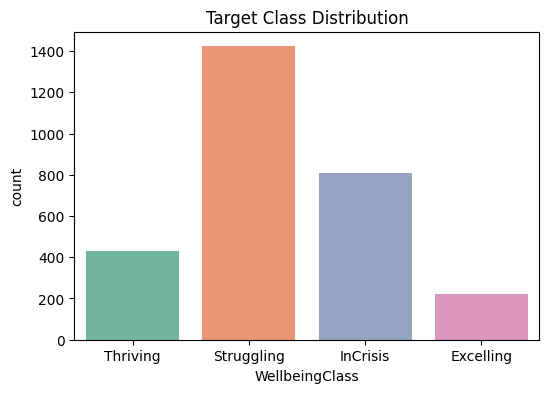

In [18]:
plt.figure(figsize=(6,4))
sns.countplot(x=target_col, data=df, palette="Set2")
plt.title("Target Class Distribution")
plt.show()

### **2. Feature Distributions per Class**


C:\Users\PC\AppData\Local\Temp\ipykernel_12940\1403923627.py:3: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=df, x=col, hue=target_col, common_norm=False, fill=True, alpha=0.4)


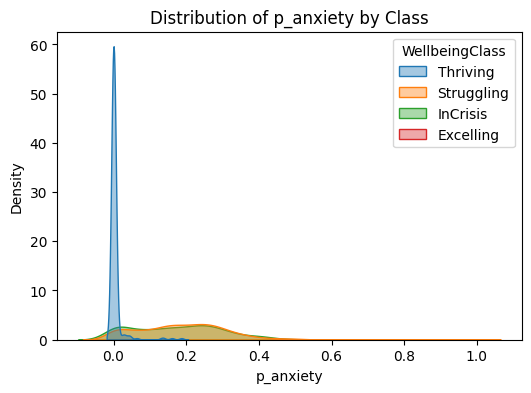

C:\Users\PC\AppData\Local\Temp\ipykernel_12940\1403923627.py:3: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=df, x=col, hue=target_col, common_norm=False, fill=True, alpha=0.4)


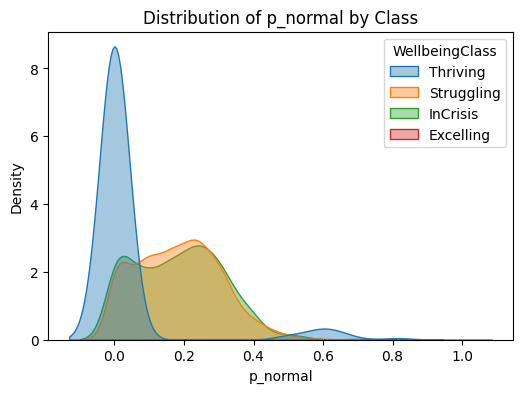

C:\Users\PC\AppData\Local\Temp\ipykernel_12940\1403923627.py:3: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=df, x=col, hue=target_col, common_norm=False, fill=True, alpha=0.4)


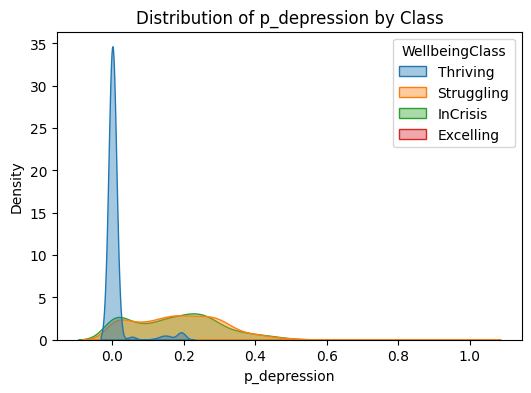

C:\Users\PC\AppData\Local\Temp\ipykernel_12940\1403923627.py:3: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=df, x=col, hue=target_col, common_norm=False, fill=True, alpha=0.4)


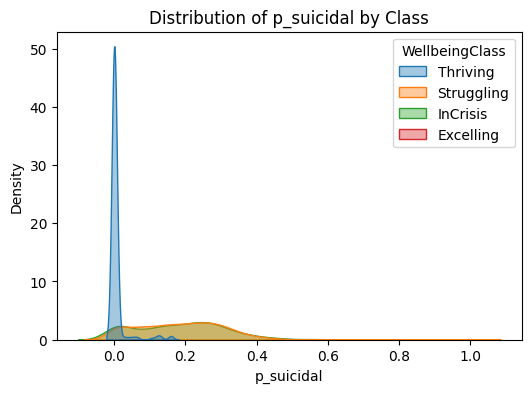

C:\Users\PC\AppData\Local\Temp\ipykernel_12940\1403923627.py:3: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=df, x=col, hue=target_col, common_norm=False, fill=True, alpha=0.4)


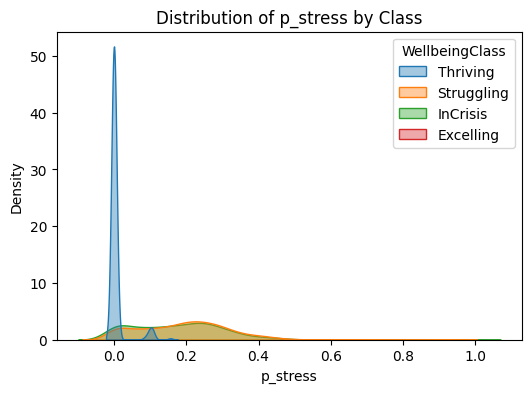

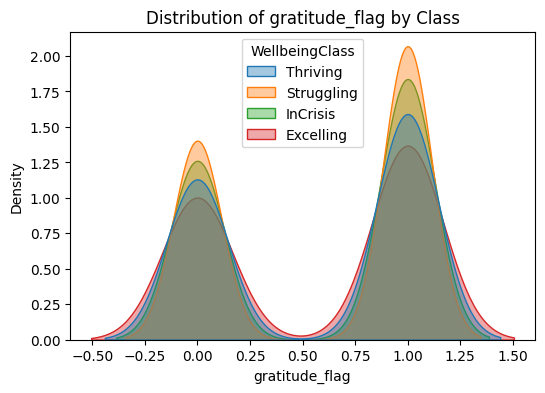

C:\Users\PC\AppData\Local\Temp\ipykernel_12940\1403923627.py:3: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=df, x=col, hue=target_col, common_norm=False, fill=True, alpha=0.4)


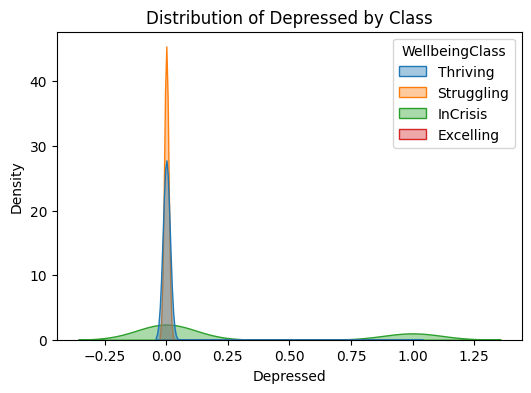

C:\Users\PC\AppData\Local\Temp\ipykernel_12940\1403923627.py:3: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=df, x=col, hue=target_col, common_norm=False, fill=True, alpha=0.4)


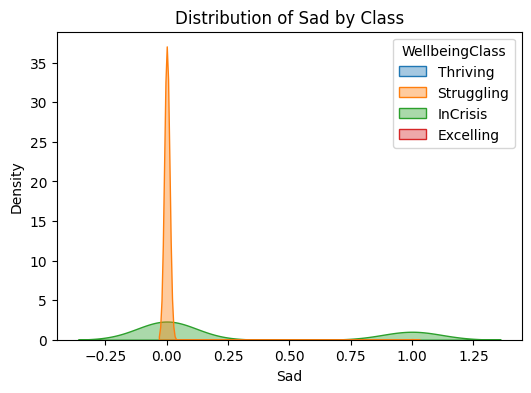

C:\Users\PC\AppData\Local\Temp\ipykernel_12940\1403923627.py:3: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=df, x=col, hue=target_col, common_norm=False, fill=True, alpha=0.4)


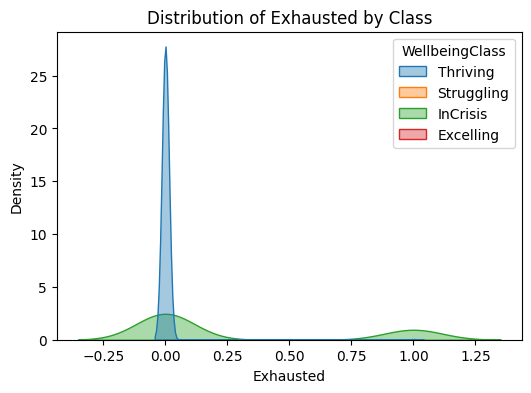

C:\Users\PC\AppData\Local\Temp\ipykernel_12940\1403923627.py:3: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=df, x=col, hue=target_col, common_norm=False, fill=True, alpha=0.4)


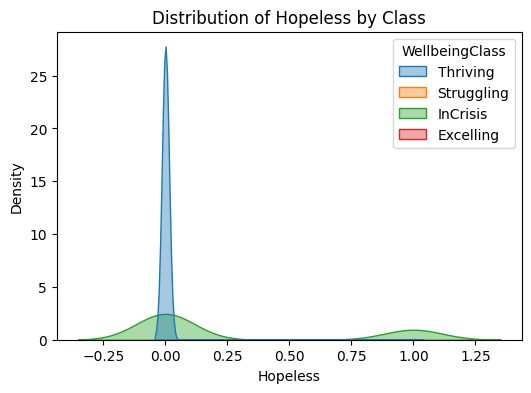

C:\Users\PC\AppData\Local\Temp\ipykernel_12940\1403923627.py:3: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=df, x=col, hue=target_col, common_norm=False, fill=True, alpha=0.4)


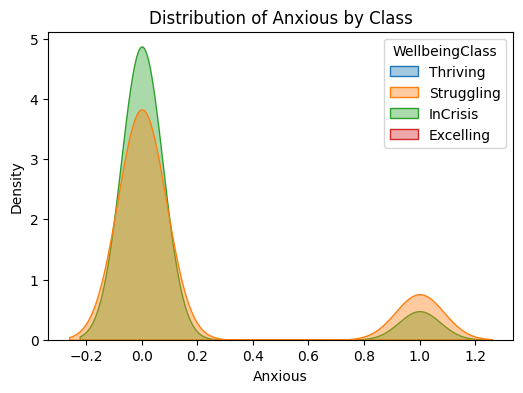

C:\Users\PC\AppData\Local\Temp\ipykernel_12940\1403923627.py:3: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=df, x=col, hue=target_col, common_norm=False, fill=True, alpha=0.4)


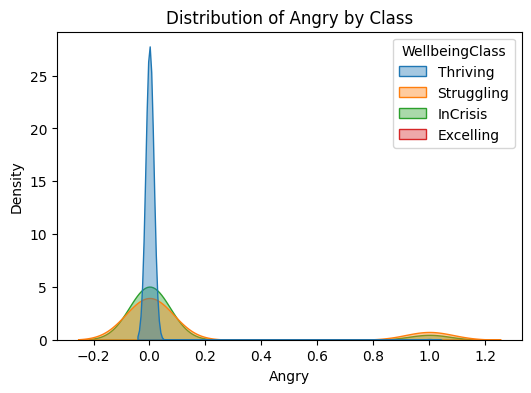

C:\Users\PC\AppData\Local\Temp\ipykernel_12940\1403923627.py:3: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=df, x=col, hue=target_col, common_norm=False, fill=True, alpha=0.4)


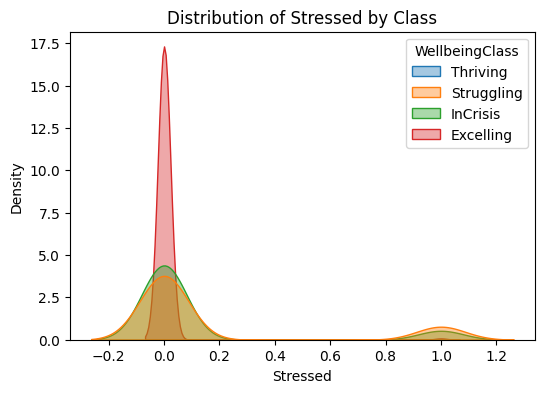

C:\Users\PC\AppData\Local\Temp\ipykernel_12940\1403923627.py:3: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=df, x=col, hue=target_col, common_norm=False, fill=True, alpha=0.4)


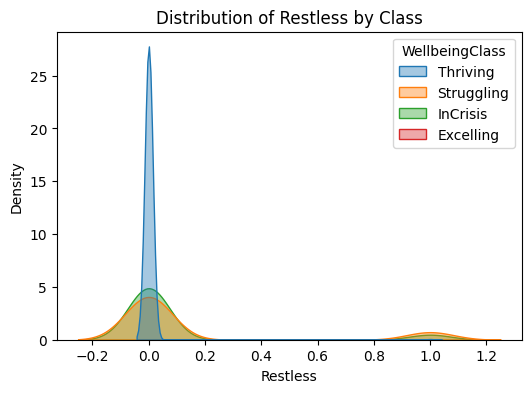

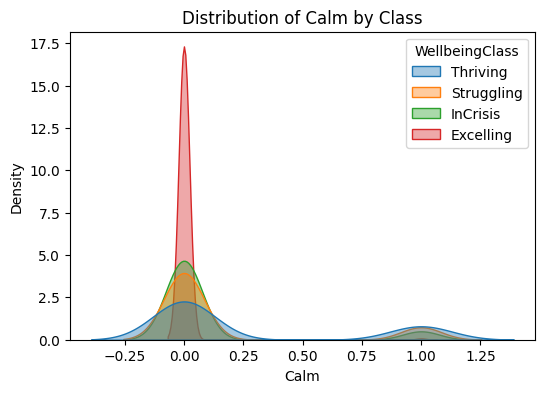

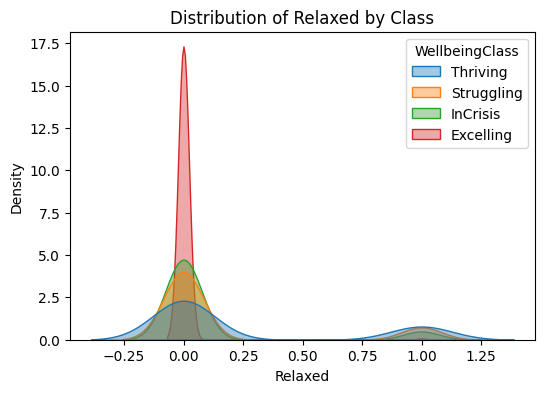

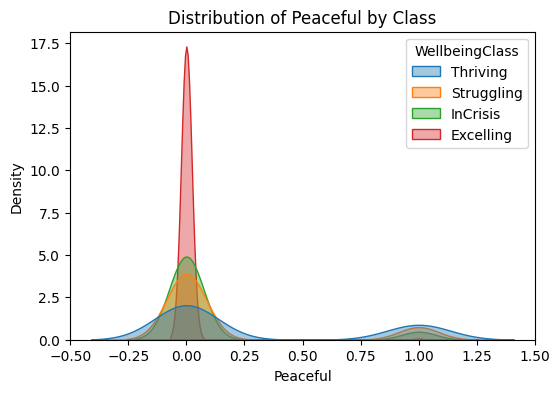

C:\Users\PC\AppData\Local\Temp\ipykernel_12940\1403923627.py:3: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=df, x=col, hue=target_col, common_norm=False, fill=True, alpha=0.4)


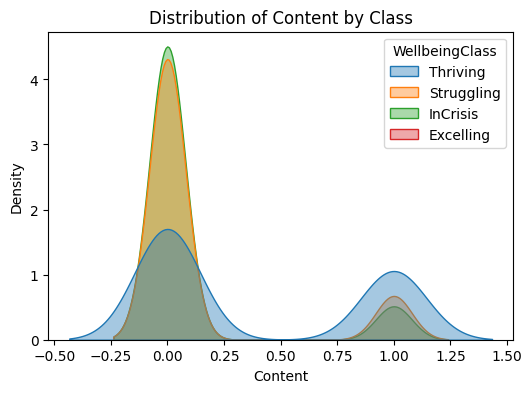

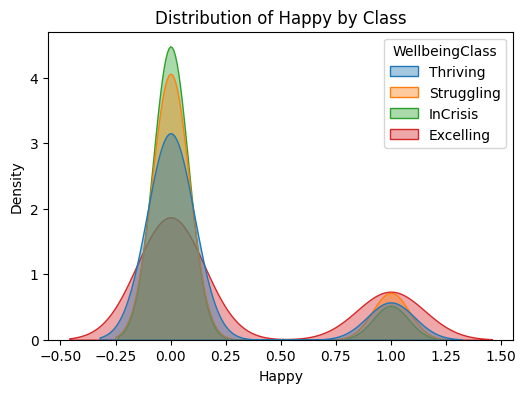

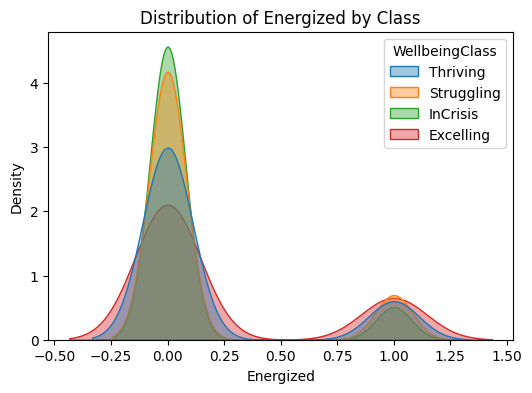

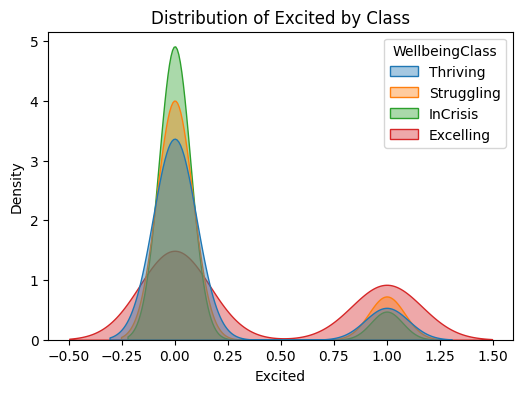

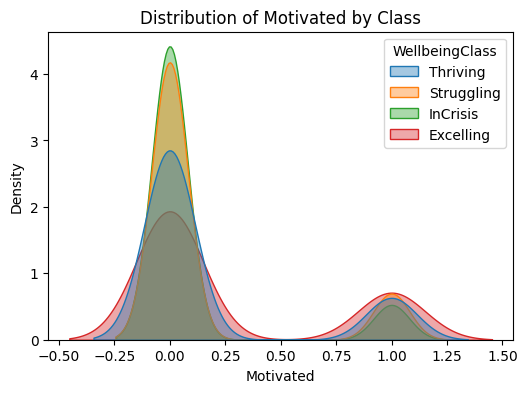

In [19]:
for col in feature_cols:
    plt.figure(figsize=(6,4))
    sns.kdeplot(data=df, x=col, hue=target_col, common_norm=False, fill=True, alpha=0.4)
    plt.title(f"Distribution of {col} by Class")
    plt.show()

### **3. Feature-Feature Correlation Heatmap**


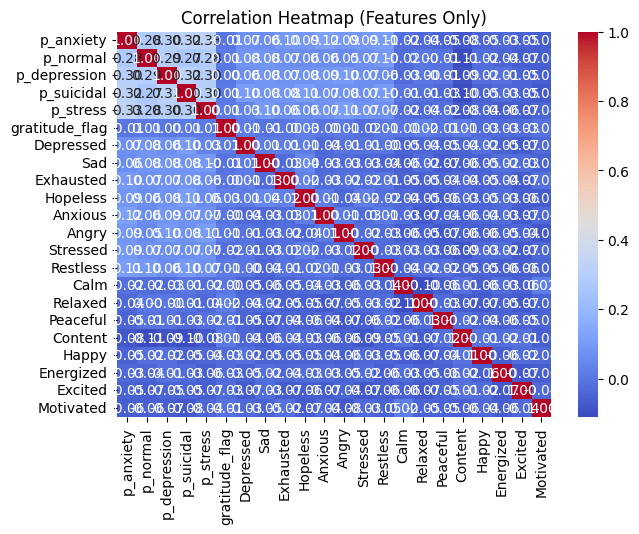

In [20]:
plt.figure(figsize=(7,5))
corr = df[feature_cols].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap (Features Only)")
plt.show()

### **4. Feature-Target Correlation (via encoding)**


In [21]:
le_temp = LabelEncoder()
y_encoded = le_temp.fit_transform(df[target_col])

corr_with_target = df[feature_cols].apply(lambda x: x.corr(pd.Series(y_encoded)))
print("\n🔎 Correlation of each feature with target:\n", corr_with_target)


🔎 Correlation of each feature with target:
 p_anxiety        -0.079723
p_normal         -0.036903
p_depression     -0.071973
p_suicidal       -0.096195
p_stress         -0.066378
gratitude_flag    0.002147
Depressed        -0.261488
Sad              -0.267902
Exhausted        -0.254701
Hopeless         -0.255326
Anxious           0.021196
Angry             0.022717
Stressed          0.006080
Restless          0.015133
Calm              0.183043
Relaxed           0.180013
Peaceful          0.215569
Content           0.246716
Happy            -0.025627
Energized         0.003645
Excited          -0.068686
Motivated        -0.005939
dtype: float64


### **5. ANOVA F-test (Feature importance vs target)**


📊 Feature Separability Scores:

           Feature     F-value        p-value  Mutual Information
0        p_anxiety  480.630190  3.411714e-253            0.353787
4         p_stress  470.425143  9.466625e-249            0.376235
3       p_suicidal  461.614336  6.884721e-245            0.361415
2     p_depression  442.224120  2.637529e-236            0.362085
7              Sad  294.360873  1.128622e-166            0.128621
1         p_normal  288.156488  1.413327e-163            0.370219
6        Depressed  280.654255  8.249794e-160            0.110367
9         Hopeless  264.180820  1.846584e-151            0.120486
8        Exhausted  262.554742  1.249198e-150            0.118160
17         Content   85.427912   5.969109e-53            0.035041
16        Peaceful   49.315607   4.472804e-31            0.034237
10         Anxious   45.971202   5.151914e-29            0.050154
12        Stressed   43.513612   1.700007e-27            0.026324
11           Angry   42.395618   8.360890e-

C:\Users\PC\AppData\Local\Temp\ipykernel_12940\2732673541.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="F-value", y="Feature", data=feat_scores, ax=axes[0], palette="viridis")
C:\Users\PC\AppData\Local\Temp\ipykernel_12940\2732673541.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Mutual Information", y="Feature", data=feat_scores.sort_values("Mutual Information", ascending=False), ax=axes[1], palette="magma")


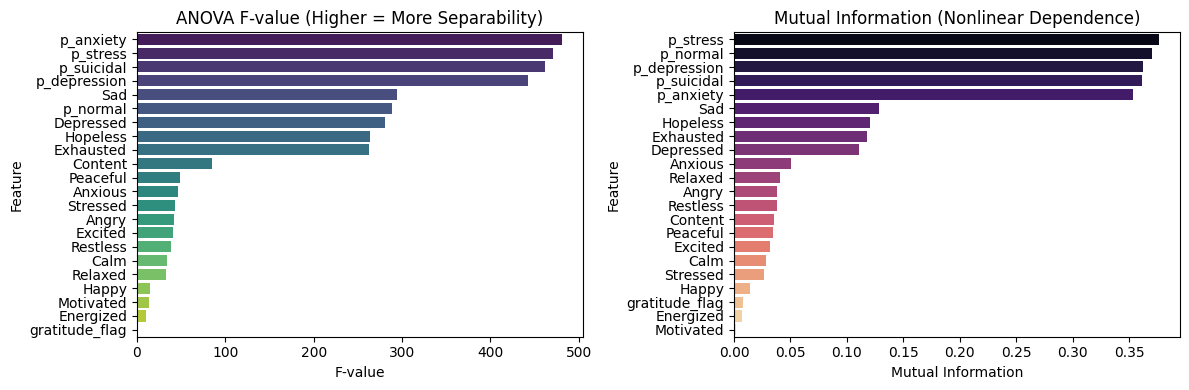

In [22]:
f_vals, p_vals = f_classif(df[feature_cols], y_encoded)
mi_vals = mutual_info_classif(df[feature_cols], y_encoded, random_state=42)

feat_scores = pd.DataFrame({
    "Feature": feature_cols,
    "F-value": f_vals,
    "p-value": p_vals,
    "Mutual Information": mi_vals
}).sort_values("F-value", ascending=False)

print("\n📊 Feature Separability Scores:\n")
print(feat_scores)

# --- Plot F-test and MI as bar chart ---
fig, axes = plt.subplots(1, 2, figsize=(12,4))

sns.barplot(x="F-value", y="Feature", data=feat_scores, ax=axes[0], palette="viridis")
axes[0].set_title("ANOVA F-value (Higher = More Separability)")

sns.barplot(x="Mutual Information", y="Feature", data=feat_scores.sort_values("Mutual Information", ascending=False), ax=axes[1], palette="magma")
axes[1].set_title("Mutual Information (Nonlinear Dependence)")

plt.tight_layout()
plt.show()

### **6. Pairplot (Scatter matrix)**

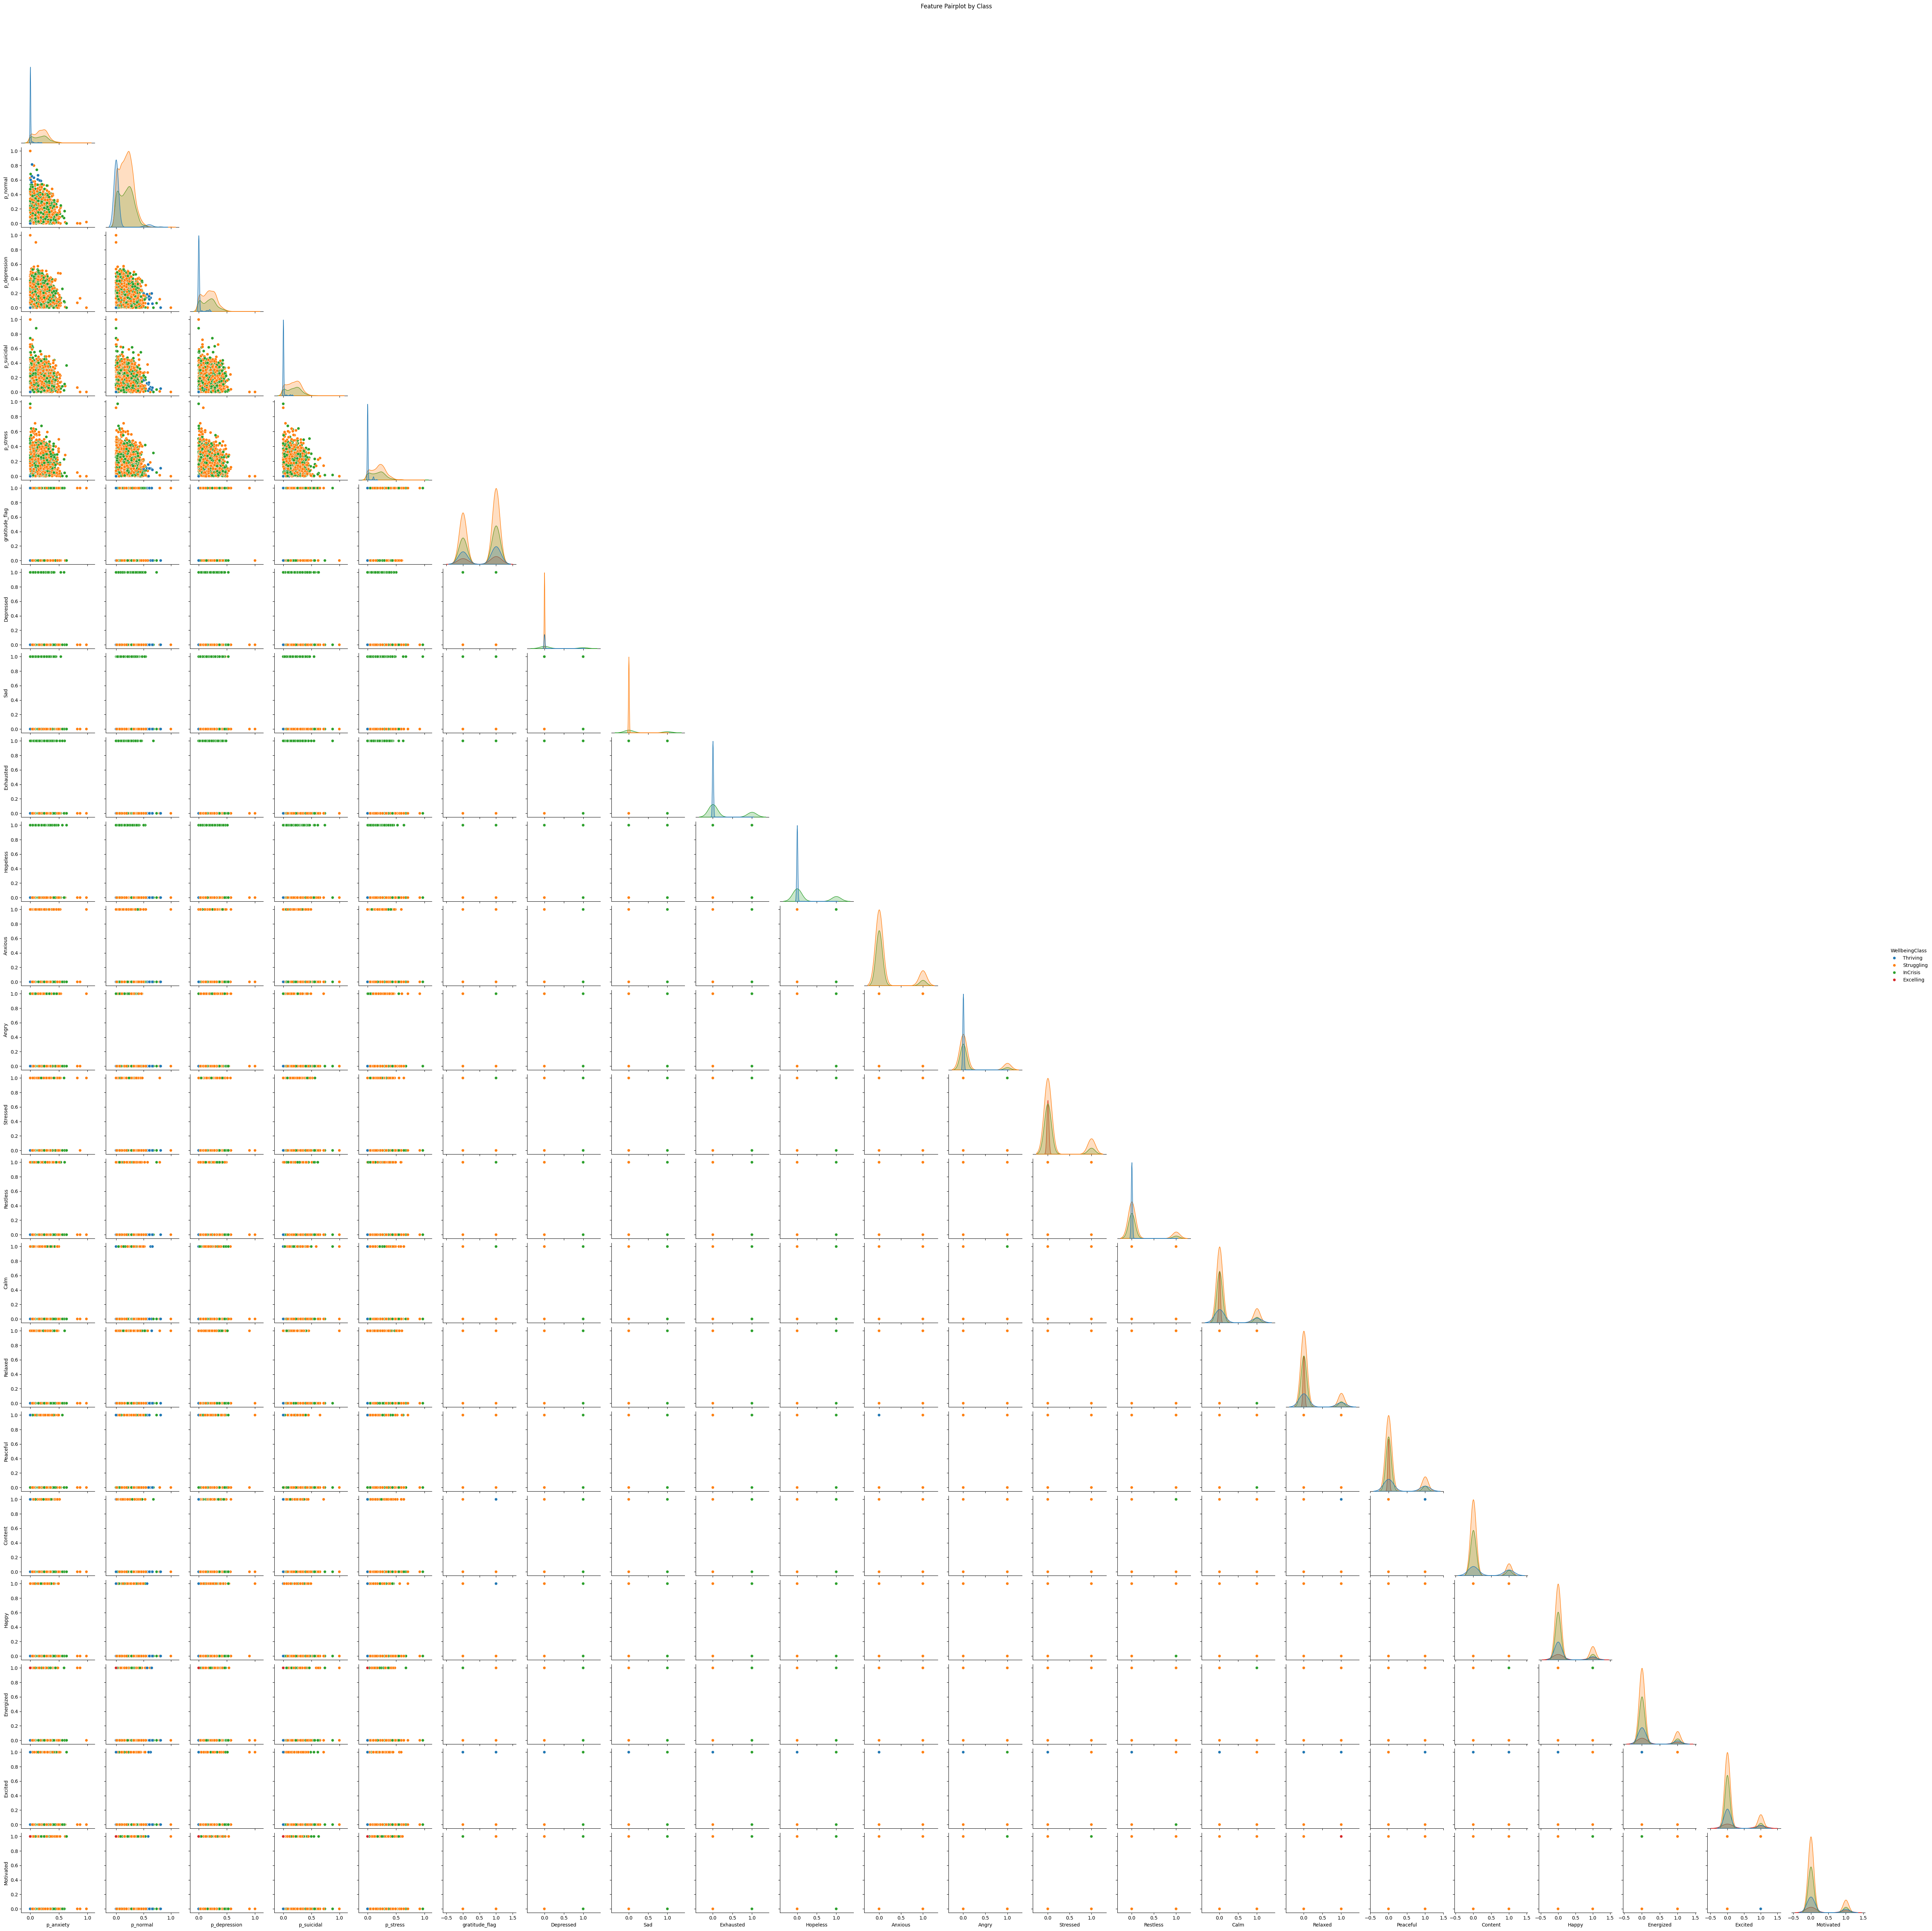

In [23]:
sns.pairplot(df[feature_cols + [target_col]], hue=target_col, diag_kind="kde", corner=True)
plt.suptitle("Feature Pairplot by Class", y=1.02)
plt.show()

### **7. PCA Visualization (2D Projection)**

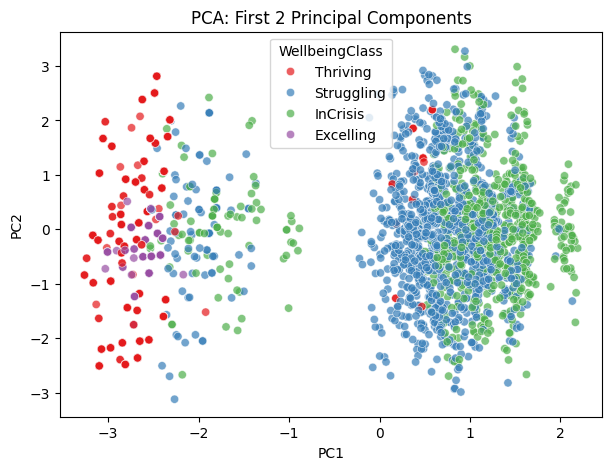

In [24]:
X_scaled = StandardScaler().fit_transform(df[feature_cols])
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
pca_df[target_col] = df[target_col]

plt.figure(figsize=(7,5))
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue=target_col, alpha=0.7, palette="Set1")
plt.title("PCA: First 2 Principal Components")
plt.show()

## Data Pre-processing


Before dropping:
p_anxiety         0
p_normal          0
p_depression      0
p_suicidal        0
p_stress          0
gratitude_flag    0
Depressed         0
Sad               0
Exhausted         0
Hopeless          0
Anxious           0
Angry             0
Stressed          0
Restless          0
Calm              0
Relaxed           0
Peaceful          0
Content           0
Happy             0
Energized         0
Excited           0
Motivated         0
dtype: int64

After dropping:
p_anxiety         0
p_normal          0
p_depression      0
p_suicidal        0
p_stress          0
gratitude_flag    0
Depressed         0
Sad               0
Exhausted         0
Hopeless          0
Anxious           0
Angry             0
Stressed          0
Restless          0
Calm              0
Relaxed           0
Peaceful          0
Content           0
Happy             0
Energized         0
Excited           0
Motivated         0
dtype: int64


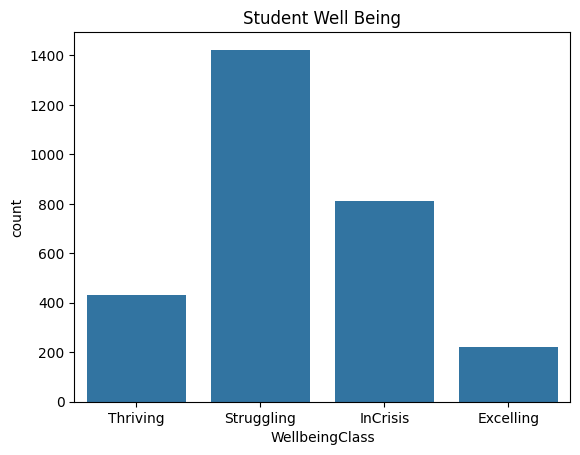

In [25]:
# Check for missing values
print("Before dropping:")
print(df[feature_cols].isna().sum())


# Drop the missing values
df = df.dropna()

# Check if missing values were dropped
print("\nAfter dropping:")
print(df[feature_cols].isna().sum())

# Class distribution
sns.countplot(x=target_col, data=df)
plt.title('Student Well Being')
plt.show()

In [26]:
# Separate features and target
X = df.drop(columns=[target_col])
y = df[target_col]

# Encode target variable
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Encode categorical features before splitting
X_encoded = pd.get_dummies(X)

# Split the data first
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y_encoded,
    test_size=0.2,
    stratify=y_encoded,
    random_state=42
)

print("Training set features dtype:\n", X_train.dtypes.unique())  # Should show only numeric types

Training set features dtype:
 [dtype('float64') dtype('int64')]


## Model training


In [27]:
rf_pipeline = Pipeline(steps=[
    ('classifier', RandomForestClassifier(random_state=42))
])

# Param grid
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [3, 5, 10, None],
    'classifier__min_samples_leaf': [1, 5, 10, 20],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__max_features': ['sqrt', 'log2']
}

# GridSearchCV setup
grid_search = GridSearchCV(
    rf_pipeline,
    param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='f1_weighted',
    n_jobs=-1
)

# Fit on original (imbalanced) training data
grid_search.fit(X_train, y_train)

# Save best model
best_model = grid_search.best_estimator_
joblib.dump(best_model, MODEL_PATH)

print("✅ Best Parameters:", grid_search.best_params_)

✅ Best Parameters: {'classifier__max_depth': None, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}


## Model Evaluation


✅ Cross-Validation Results Summary:



,mean_test_score,std_test_score,params
0,0.981062,0.009138,"{'classifier__max_depth': None, 'classifier__m..."
1,0.981062,0.009138,"{'classifier__max_depth': None, 'classifier__m..."
2,0.980631,0.010090,"{'classifier__max_depth': None, 'classifier__m..."
3,0.980631,0.010090,"{'classifier__max_depth': None, 'classifier__m..."
4,0.980615,0.010675,"{'classifier__max_depth': None, 'classifier__m..."
...,...,...,...
187,0.647128,0.005172,"{'classifier__max_depth': 3, 'classifier__max_..."
188,0.647128,0.005172,"{'classifier__max_depth': 3, 'classifier__max_..."
189,0.647128,0.005172,"{'classifier__max_depth': 3, 'classifier__max_..."
190,0.647128,0.005172,"{'classifier__max_depth': 3, 'classifier__max_..."



📊 Classification Report (Test Set):



,precision,recall,f1-score,support
Excelling,1.000,1.000,1.000,44.000
InCrisis,0.994,0.981,0.988,162.000
Struggling,0.996,0.975,0.986,285.000
Thriving,0.915,1.000,0.956,86.000
accuracy,0.983,0.983,0.983,0.983
macro avg,0.976,0.989,0.982,577.000
weighted avg,0.984,0.983,0.983,577.000



⚖️ Balanced Accuracy: 0.9892

🔎 Confusion Matrix:



,Pred_Excelling,Pred_InCrisis,Pred_Struggling,Pred_Thriving
True_Excelling,44,0,0,0
True_InCrisis,0,159,1,2
True_Struggling,0,1,278,6
True_Thriving,0,0,0,86


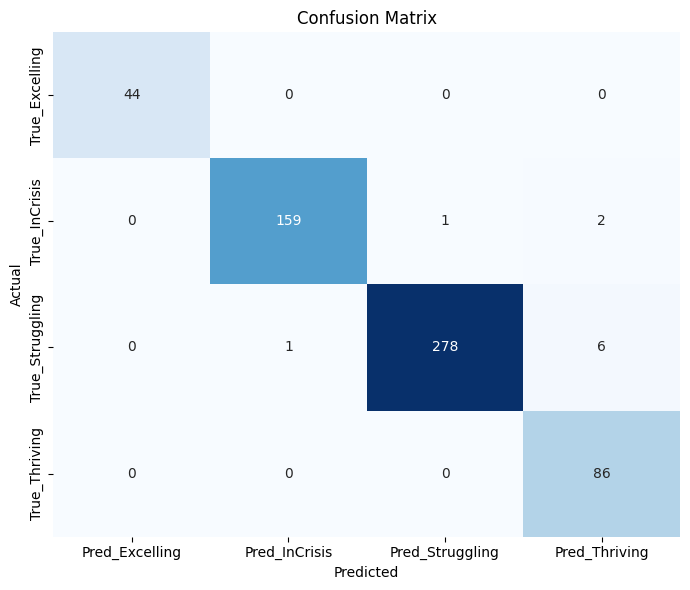


🌀 Classification Report (Shuffled Labels Baseline):



,precision,recall,f1-score,support
Excelling,0.200,0.205,0.202,44.000
InCrisis,0.319,0.142,0.197,162.000
Struggling,0.611,0.891,0.725,285.000
Thriving,0.386,0.198,0.262,86.000
accuracy,0.525,0.525,0.525,0.525
macro avg,0.379,0.359,0.346,577.000
weighted avg,0.464,0.525,0.468,577.000


In [28]:
# --- Cross-Validation Results ---
cv_results_df = pd.DataFrame(grid_search.cv_results_)
cv_summary = cv_results_df[['mean_test_score', 'std_test_score', 'params']] \
    .sort_values(by='mean_test_score', ascending=False) \
    .reset_index(drop=True)

print("\n✅ Cross-Validation Results Summary:\n")
display(cv_summary)

# --- Predictions on Test Set ---
y_pred = grid_search.predict(X_test)

# Decode labels back to class names
y_test_labels = le.inverse_transform(y_test)
y_pred_labels = le.inverse_transform(y_pred)
class_names = le.classes_

# --- Classification Report ---
report_dict = classification_report(
    y_test_labels, y_pred_labels, labels=class_names,
    output_dict=True, zero_division=0
)
report_df = pd.DataFrame(report_dict).T

print("\n📊 Classification Report (Test Set):\n")
display(report_df.round(3))

# --- Balanced Accuracy ---
bal_acc = balanced_accuracy_score(y_test_labels, y_pred_labels)
print(f"\n⚖️ Balanced Accuracy: {bal_acc:.4f}")

# --- Confusion Matrix ---
cm = confusion_matrix(y_test_labels, y_pred_labels, labels=class_names)

cm_df = pd.DataFrame(
    cm, index=[f"True_{cls}" for cls in class_names],
    columns=[f"Pred_{cls}" for cls in class_names]
)

print("\n🔎 Confusion Matrix:\n")
display(cm_df)

plt.figure(figsize=(7,6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# --- Shuffled Labels Baseline ---
from sklearn.utils import shuffle
baseline_model = RandomForestClassifier(class_weight='balanced', random_state=42)

y_shuffled = shuffle(y_train, random_state=42)
baseline_model.fit(X_train, y_shuffled)
y_pred_shuffled = baseline_model.predict(X_test)

y_pred_shuffled_labels = le.inverse_transform(y_pred_shuffled)

baseline_report_dict = classification_report(
    y_test_labels, y_pred_shuffled_labels,
    labels=class_names, output_dict=True, zero_division=0
)
baseline_report_df = pd.DataFrame(baseline_report_dict).T

print("\n🌀 Classification Report (Shuffled Labels Baseline):\n")
display(baseline_report_df.round(3))
